In [176]:
from _Setup import *
from data_functions import *

import tensorflow as tf
from keras import layers

## Import train and test data

In [177]:
train_data = pd.read_csv(rawTrainFile)
test_data = pd.read_csv(rawTestFile)

C:\Users\Trevo\AppData\Local\Temp\ipykernel_32552\3702163432.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(rawTestFile)


# Train data preparation

### Remove Columns w/ > 95% initial missing values and B/F imputation

In [178]:
# Identify columns with more than 90% missing values

missing_percentage = train_data.isnull().mean() * 100

cols_to_drop_for_missing_percentage = missing_percentage[missing_percentage > 90].index

# Drop the identified columns

train_truncated = train_data.drop(columns=cols_to_drop_for_missing_percentage)
test_truncated = test_data.drop(columns = cols_to_drop_for_missing_percentage)
cols_to_drop_for_missing_percentage

Index(['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
       'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets'],
      dtype='object')

In [179]:
#forward imputation
train_forward = forward_fill_by_patient(train_truncated)
test_forward = forward_fill_by_patient(test_truncated)
train_forward.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,106.0,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,106.0,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,96.0,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,96.0,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [180]:
#backward imputation
pre_imputed_train = backward_fill_by_patient(train_forward)
pre_imputed_test = backward_fill_by_patient(test_forward)
pre_imputed_train.head()  

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,78.0,99.5,35.25,108.5,84.5,69.0,12.0,106.0,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,106.0,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,106.0,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,96.0,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,96.0,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [181]:
# Identify columns with more than 90% missing values

missing_percentage = pre_imputed_train.isnull().mean() * 100

cols_to_drop_for_missing_percentage2 = missing_percentage[missing_percentage > 80].index

cols_to_drop_for_missing_percentage2

Index([], dtype='object')

## MissForest imputation

In [182]:
naPercentages = pd.DataFrame(pre_imputed_train.isna().sum() / pre_imputed_train.shape[0], columns=['Percentage'])
naPercentages.sort_values(by = ['Percentage'], ascending=False)           

,Percentage
Unit1,0.391502
Unit2,0.391502
DBP,0.166844
Glucose,0.026092
SBP,0.006932
Temp,0.004656
MAP,0.001887
Resp,0.001336
O2Sat,0.000301
HR,0.000130


In [183]:
# Solve a bug within the test data
pre_imputed_test['HR'] = pd.to_numeric(pre_imputed_test['HR'], errors='coerce')

In [184]:
imputer = MissForest()

imputer_input = pre_imputed_train.drop('SepsisLabel', axis = 1)
imputed_data = imputer.fit_transform(imputer_input)
imputed_test = imputer.transform(pre_imputed_test)

imputed_data['SepsisLabel'] = pre_imputed_train['SepsisLabel']

imputed_data.isna().sum()

100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
Glucose        0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
dtype: int64

## Fixing unit1 and unit2 problem

In [185]:
# Convert to binary values
imputed_data['Unit1'] = imputed_data['Unit1'].apply(lambda x: 1 if x >= 0.5 else 0)
imputed_data['Unit2'] = imputed_data['Unit2'].apply(lambda x: 1 if x >= 0.5 else 0)
 
imputed_test['Unit1'] = imputed_test['Unit1'].apply(lambda x: 1 if x >= 0.5 else 0)
imputed_test['Unit2'] = imputed_test['Unit2'].apply(lambda x: 1 if x >= 0.5 else 0)
 
 # Print the unique values again to verify
print("Unique values in Unit1 after transformation:")
print(imputed_data['Unit1'].unique())
 
print("\nUnique values in Unit2 after transformation:")
print(imputed_data['Unit2'].unique())


Unique values in Unit1 after transformation:
[0 1]

Unique values in Unit2 after transformation:
[1 0]


# Workflow:

1. Train/Validation Split
2. Minority oversampling by patient

--- Separate Files Here ---

3. Build RNN
4. Evaluate Performance



In [186]:
# Create variable to see if patient ever has sepsis
imputed_data['SepsisPatient'] = imputed_data.groupby('patient')['SepsisLabel'].transform(lambda x: 1 if (x == 1).any() else 0)


# Create create [patient, SepsisEver] pair to take stratified sample
patientsList = imputed_data.drop_duplicates(subset=['patient', 'SepsisPatient'])[['patient', 'SepsisPatient']]

X_sample = patientsList['patient']
y_sample =  patientsList['SepsisPatient']

# Take stratified sample based upon whether individual ever has Sepsis
patient_labels_train, patient_labels_validate, _, _ = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample)


In [187]:
# Reexpand Train Data
train_split_data = imputed_data[imputed_data['patient'].isin(patient_labels_train)].drop('SepsisPatient', axis = 1)
validate_split_data = imputed_data[imputed_data['patient'].isin(patient_labels_validate)].drop('SepsisPatient', axis = 1)
validate_split_data.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
143,8096,1,84.0,100.0,36.10,122.5,74.5,53.0,13.00,128.0,88.35,0.0,0,1,-140.45,1.0,0.0
144,8096,2,84.0,100.0,36.10,122.5,74.5,53.0,13.00,128.0,88.35,0.0,0,1,-140.45,2.0,0.0
145,8096,3,85.0,100.0,36.55,140.0,84.5,56.0,18.00,128.0,88.35,0.0,0,1,-140.45,3.0,0.0
146,8096,4,80.0,100.0,36.80,133.5,78.5,57.0,19.00,128.0,88.35,0.0,0,1,-140.45,4.0,0.0
147,8096,5,80.0,100.0,37.00,136.5,96.0,59.5,19.25,128.0,88.35,0.0,0,1,-140.45,5.0,0.0


### TODO : Minority oversampling?

### TODO : Feature Engineering

In [188]:
featured_train = FeatureEngineering(train_split_data)
featured_validate = FeatureEngineering(validate_split_data)
featured_test = FeatureEngineering(imputed_test)

In [189]:
# Scale train data 

# exclude_scaling_cols = ['time', 'patient', 'Gender', 'Unit1', 'Unit2', 'Fever', 'TCP', 'TCA', 'LEU']
exclude_scaling_cols = ['time', 'patient', 'Gender',  'TCA']

# Separate columns into those to scale and those to exclude
cols_to_scale = featured_train.drop(columns=exclude_scaling_cols + ['SepsisLabel']).columns
scaled_data = featured_train[cols_to_scale]

# Scale the selected columns
scaler = StandardScaler()
scaled_scaled_data = pd.DataFrame(scaler.fit_transform(scaled_data), columns=cols_to_scale)

# Combine scaled data with excluded columns and the target variable
scaled_train = pd.concat(
    [scaled_scaled_data, 
     featured_train[exclude_scaling_cols].reset_index(drop=True), 
     featured_train['SepsisLabel'].reset_index(drop=True)], 
    axis=1
)

# Display the resulting DataFrame
print(scaled_train.head())

         HR     O2Sat      Temp       SBP       MAP       DBP      Resp  \
0 -0.365409  0.745006 -2.228313 -0.645498  0.111362  0.386073 -1.285522   
1 -0.365409  0.745006 -2.228313 -0.645498  0.111362  0.386073 -1.285522   
2 -0.250669  0.586622 -0.910847 -0.451994  0.263388  0.678252 -1.285522   
3 -0.308039  0.903390 -0.494805 -0.494995  0.020146  0.313028 -1.285522   
4 -0.652259  0.903390 -0.494805 -0.365993 -0.162286  0.020848 -1.479300   

    Glucose       Age     Unit1     Unit2  HospAdmTime    ICULOS     Shock  \
0 -0.546811 -0.301226 -0.657063  0.657063      0.30572 -0.885515  0.047678   
1 -0.546811 -0.301226 -0.657063  0.657063      0.30572 -0.851759  0.047678   
2 -0.546811 -0.301226 -0.657063  0.657063      0.30572 -0.818004 -0.004651   
3 -0.759121 -0.301226 -0.657063  0.657063      0.30572 -0.784248 -0.017135   
4 -0.759121 -0.301226 -0.657063  0.657063      0.30572 -0.750492 -0.355035   

   time  patient  Gender  TCA  SepsisLabel  
0     1    16426     1.0    0      

In [190]:
# Scale Validation Data
scaled_val = featured_validate[cols_to_scale]

scaled_val_data = pd.DataFrame(scaler.transform(scaled_val), columns=cols_to_scale)
scaled_val = pd.concat([scaled_val_data, 
                         featured_validate[exclude_scaling_cols].reset_index(drop = True), 
                         featured_validate['SepsisLabel'].reset_index(drop = True)],
                         axis = 1)

scaled_val.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Unit1,Unit2,HospAdmTime,ICULOS,Shock,time,patient,Gender,TCA,SepsisLabel
0,-0.021189,0.90339,-1.049527,-0.043486,-0.496743,-0.782645,-1.091744,-0.07973,1.604103,-0.657063,0.657063,-0.46644,-0.885515,-0.111182,1,8096,0.0,0,0.0
1,-0.021189,0.90339,-1.049527,-0.043486,-0.496743,-0.782645,-1.091744,-0.07973,1.604103,-0.657063,0.657063,-0.46644,-0.851759,-0.111182,2,8096,0.0,0,0.0
2,0.036181,0.90339,-0.425464,0.709029,0.111362,-0.563511,-0.122853,-0.07973,1.604103,-0.657063,0.657063,-0.46644,-0.818004,-0.487370,3,8096,0.0,0,0.0
3,-0.250669,0.90339,-0.078763,0.429523,-0.253501,-0.490466,0.070925,-0.07973,1.604103,-0.657063,0.657063,-0.46644,-0.784248,-0.525156,4,8096,0.0,0,0.0
4,-0.250669,0.90339,0.198599,0.558526,0.810682,-0.307854,0.119369,-0.07973,1.604103,-0.657063,0.657063,-0.46644,-0.750492,-0.588214,5,8096,0.0,0,0.0


In [191]:
# Scale test data

scaled_test_cols = featured_test.drop(columns = exclude_scaling_cols).columns
scaled_test = featured_test[scaled_test_cols]

scaled_test_data = pd.DataFrame(scaler.transform(scaled_test), columns=scaled_test_cols)
scaled_test = pd.concat([scaled_test_data, 
                         featured_test[exclude_scaling_cols].reset_index(drop = True)], 
                         axis = 1)

In [192]:
# Save to CSV's 
rnnTrainFile = os.path.join(imputedDataPath, "rnn_train.csv")
rnnValFile = os.path.join(imputedDataPath, "rnn_val.csv")
rnnTestFile = os.path.join(imputedDataPath, "rnn_test.csv")

scaled_train.to_csv(rnnTrainFile, index=False)
scaled_val.to_csv(rnnValFile, index=False)
scaled_test.to_csv(rnnTestFile, index=False)

# IF THE PIPELINE BREAKS START RUN HERE

In [1]:
from _Setup import *
from data_functions import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

scaled_train = pd.read_csv(rnnTrainFile)
scaled_val = pd.read_csv(rnnValFile)
scaled_test = pd.read_csv(rnnTestFile)

In [124]:
whole_train = pd.concat([scaled_train, scaled_val], axis = 1)

In [2]:
def pad_data(df):

    # Group by patient
    grouped = df.groupby('patient', sort=False)

    # Initialize lists to store sequences and corresponding labels
    sequences = []
    labels = []
    lengths = []

    for patient_id, group in grouped:
        # Extract features (excluding 'patient', 'time', 'SepsisLabel')
        features = group.drop(columns=['patient', 'time', 'SepsisLabel'])

        # Extract the target labels (SepsisLabel for each time step)
        label = group['SepsisLabel'].values

        # Convert features to tensor
        feature_tensor = torch.tensor(features.values, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        sequences.append(feature_tensor)
        labels.append(label_tensor)
        lengths.append(len(feature_tensor))

    # Pad sequences (padding with 0.0)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-1.0)  # use -1 for padding in labels
    lengths = torch.tensor(lengths)

    return padded_sequences, padded_labels, lengths


In [3]:
padded_train, labels_train, mask_train = pad_data(scaled_train)

In [4]:
padded_val, labels_val, mask_val = pad_data(scaled_val)

In [5]:
print(padded_train.shape)

torch.Size([22588, 336, 16])


In [116]:
# Define the model
class PanelRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.3):
        super(PanelRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # Output is SepsisLabel per time step
    
    def forward(self, x, lengths):
        # Pack the padded sequences
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Pass the packed input through the RNN
        packed_output, _ = self.rnn(packed_input)
        
        # Unpack the output to restore padding
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Pass through a fully connected layer to get final output
        output = self.fc(output)  # Shape: (batch_size, max_len, output_size)
        
        return output

In [117]:
# Prepare the input (padded sequences and labels)

# Initialize the model
input_size = padded_train.size(-1)  # Number of features (e.g., HR, O2Sat, etc.)
hidden_size = 12  # Hidden state size
output_size = 1  # SepsisLabel prediction (binary)

model = PanelRNN(input_size, hidden_size, output_size)

class_weights = torch.tensor([0.1, 0.9])  # Example weights for class 0 and class 1

# Forward pass
output = model(padded_train, mask_train)

In [118]:
import torch.optim as optim
from torch import nn

# Binary Cross-Entropy loss (for binary classification)
criterion = nn.BCEWithLogitsLoss(weight=None, reduction='none')  # We want to calculate loss for each time step

# Optimizer
# TODO : Mess with the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.04)
early_stopping_threshold = 0.02  # Minimum change in loss to qualify as an improvement

# Example training loop
for epoch in range(20):  # Number of epochs
    model.train()
    
    # Forward pass
    output = model(padded_train, mask_train)
    
    # Mask out padding in the labels (padding value is -1)
    mask = labels_train != -1  # True for valid time steps
    masked_labels = labels_train * mask.float()  # Mask out padding
    
    # Ensure output shape is (batch_size, seq_len) by squeezing the last dimension
    output = output.squeeze(-1)  # Squeeze output to shape (batch_size, seq_len)

    # Now expand the class weights to match the shape of the output
    # Class weights should be applied to each time step and each instance in the batch
    expanded_weights = class_weights[masked_labels.long()]  # Select class weights for each label (0 or 1)
    expanded_weights = expanded_weights * mask.float()  # Apply the mask to ensure we only weight valid time steps

    # Compute the loss for each time step
    loss = criterion(output, masked_labels)  # Output shape: (batch_size, seq_len), Labels shape: (batch_size, seq_len)

    # Apply the class weights to the loss (element-wise multiplication)
    weighted_loss = loss * expanded_weights

    # Apply mask to ignore padding in the loss calculation
    loss = weighted_loss.sum() / mask.sum()  # Normalize by the number of valid time steps
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

    if loss < early_stopping_threshold:
        break

Epoch [1/10], Loss: 0.0836
Epoch [2/10], Loss: 0.0638
Epoch [3/10], Loss: 0.0520
Epoch [4/10], Loss: 0.0468
Epoch [5/10], Loss: 0.0468
Epoch [6/10], Loss: 0.0469
Epoch [7/10], Loss: 0.0463
Epoch [8/10], Loss: 0.0444
Epoch [9/10], Loss: 0.0438
Epoch [10/10], Loss: 0.0426
Epoch [11/10], Loss: 0.0422
Epoch [12/10], Loss: 0.0426
Epoch [13/10], Loss: 0.0423
Epoch [14/10], Loss: 0.0420
Epoch [15/10], Loss: 0.0417
Epoch [16/10], Loss: 0.0416
Epoch [17/10], Loss: 0.0415
Epoch [18/10], Loss: 0.0415
Epoch [19/10], Loss: 0.0413
Epoch [20/10], Loss: 0.0411


In [119]:
# Set the model to evaluation mode (disables dropout, batch normalization, etc.)
model.eval()
threshold = 0.585

# No need to compute gradients during evaluation
with torch.no_grad():
    # Pass the scaled validation data through the model
    predictions = model(padded_val, mask_val)

    # Apply the sigmoid activation to get probabilities for the positive class (SepsisLabel == 1)
    predicted_probs = torch.sigmoid(predictions).squeeze(-1)  # Shape: (batch_size, max_seq_len)

    # Convert the probabilities to binary labels (0 or 1) using a threshold of 0.5
    predicted_labels = (predicted_probs > threshold).float()  # Shape: (batch_size, max_seq_len)

    print("Predicted Probabilities:\n", predicted_probs)

Predicted Probabilities:
 tensor([[0.0827, 0.0831, 0.0820,  ..., 0.4154, 0.4154, 0.4154],
        [0.0815, 0.0823, 0.0821,  ..., 0.4154, 0.4154, 0.4154],
        [0.1258, 0.0930, 0.0984,  ..., 0.4154, 0.4154, 0.4154],
        ...,
        [0.0818, 0.0823, 0.0821,  ..., 0.4154, 0.4154, 0.4154],
        [0.0826, 0.0833, 0.0824,  ..., 0.4154, 0.4154, 0.4154],
        [0.1475, 0.1323, 0.1547,  ..., 0.4154, 0.4154, 0.4154]])


In [120]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Mask out the padding values in the true labels (e.g., padding is marked as -1)
mask = labels_val != -1  # True for valid time steps, False for padding

# Mask the predictions (only consider valid time steps for evaluation)
masked_pred_labels = predicted_labels * mask.float()
masked_true_labels = labels_val * mask.float()

# Flatten the predictions and true labels for computing metrics
masked_pred_labels_flat = masked_pred_labels.flatten()
masked_true_labels_flat = masked_true_labels.flatten()

# Compute precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(
    masked_true_labels_flat, masked_pred_labels_flat, average='binary'
)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Compute ROC AUC (Area Under the Curve)
# Flatten the probabilities and true labels for AUC calculation
masked_pred_probs_flat = predicted_probs.flatten()
masked_true_labels_flat_auc = masked_true_labels.flatten()

# Compute ROC AUC score
auc = roc_auc_score(masked_true_labels_flat_auc, masked_pred_probs_flat)
print(f"ROC AUC: {auc:.4f}")

Precision: 0.1675, Recall: 0.1403, F1 Score: 0.1527
ROC AUC: 0.3188


In [121]:
from sklearn import metrics
thresh = np.arange(0.1,0.9,0.005)

f1_list = []
precision_list = []
recall_list = []
for t in thresh:
    predicted_labels = (predicted_probs > t).float()
    mask = labels_val != -1
    masked_pred_labels = predicted_labels * mask.float()
    masked_true_labels = labels_val * mask.float()
    masked_pred_labels_flat = masked_pred_labels.flatten()
    masked_true_labels_flat = masked_true_labels.flatten()
    precision, recall, f1, _ = precision_recall_fscore_support(
    masked_true_labels_flat, masked_pred_labels_flat, average='binary'
)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)
    
dict = {"thresh":thresh, "f1":f1_list, "precision": precision_list, "recall":recall_list}


df_f1 = pd.DataFrame(dict)

c:\Users\Trevo\anaconda3\envs\sepsis\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Trevo\anaconda3\envs\sepsis\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Trevo\anaconda3\envs\sepsis\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Trevo\anaconda3\env

thresh       0.405000
f1           0.167813
precision    0.118517
recall       0.287324
Name: 61, dtype: float64

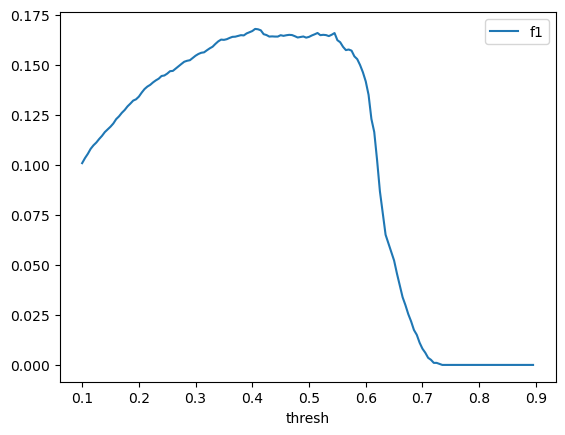

In [122]:
df_f1.plot(x = 'thresh', y = 'f1')
max_index = df_f1['f1'].idxmax()
df_f1.iloc[max_index]

In [123]:

val_binary_predictions = np.where(predicted_probs > .49, 1, 0).flatten()
print("\nClassification Report (Training):\n", metrics.classification_report(masked_true_labels_flat.numpy(), val_binary_predictions))
f1 = metrics.f1_score(masked_true_labels_flat.numpy(), val_binary_predictions )
print("F1 Score (Training):", f1)


Classification Report (Training):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2396070
         1.0       0.13      0.24      0.16      3905

    accuracy                           1.00   2399975
   macro avg       0.56      0.62      0.58   2399975
weighted avg       1.00      1.00      1.00   2399975

F1 Score (Training): 0.16403056690954326


In [125]:
padded_whole, labels_whole, mask_whole = pad_data(scaled_val)

In [41]:
def pad_data_test(df):

    # Group by patient
    grouped = df.groupby('patient', sort=False)

    # Initialize lists to store sequences and corresponding labels
    sequences = []
    labels = []
    lengths = []

    for patient_id, group in grouped:
        # Extract features (excluding 'patient', 'time', 'SepsisLabel')
        features = group.drop(columns=['patient', 'time'])

        # Convert features to tensor
        feature_tensor = torch.tensor(features.values, dtype=torch.float32)

        sequences.append(feature_tensor)
        lengths.append(len(feature_tensor))

    # Pad sequences (padding with 0.0)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    lengths = torch.tensor(lengths)

    return padded_sequences, lengths


In [42]:
padded_test, mask_test = pad_data_test(scaled_test)

In [43]:
# Set the model to evaluation mode (disables dropout, batch normalization, etc.)
model.eval()

# No need to compute gradients during evaluation
with torch.no_grad():
    # Pass the scaled validation data through the model
    predictions = model(padded_test, mask_test)

    # Apply the sigmoid activation to get probabilities for the positive class (SepsisLabel == 1)
    predicted_probs = torch.sigmoid(predictions).squeeze(-1)  # Shape: (batch_size, max_seq_len)

    # Convert the probabilities to binary labels (0 or 1) using a threshold of 0.5
    predicted_test = (predicted_probs > threshold).float()  # Shape: (batch_size, max_seq_len)



In [44]:
# Using a list to collect final predictions for valid positions
final_preds = []

# Iterate over rows in batch
for row in range(padded_test.shape[0]):
    valid_length = mask_test[row]  # Number of valid time steps in the current row
    final_preds.append(predicted_test[row, :valid_length])  # Slice the first `valid_length` predictions

# Convert list of valid predictions into a 1D array (flat)
final_preds = np.concatenate(final_preds)

# final_preds is now a 1D array containing only the valid predictions
print(final_preds)

[0. 0. 0. ... 0. 0. 0.]


In [59]:
submission = pd.read_csv(rawSubmissionFile, index_col = 0)
submission.head()

,SepsisLabel
ID,
6560_1,0
6560_2,0
6560_3,0
6560_4,0
6560_5,0


In [60]:
final_preds.shape

(464354,)

In [61]:
submission["SepsisLabel"]= final_preds

In [62]:
submission.head()

,SepsisLabel
ID,
6560_1,0.0
6560_2,0.0
6560_3,0.0
6560_4,0.0
6560_5,0.0


In [63]:
submission.to_csv("../Data/imputedData/RNN_submission.csv")